# Results inspection notebook
- This notebook loads the experiment `args.json`, `pre-train.pkl`, `post-train.pkl`, and optionally `compression.pkl`.

In [ ]:

import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import jsonschema
import pytest

sns.set(style='whitegrid')
%matplotlib inline

In [13]:
results_dir = Path('Results/data/singleshot/cifar_rand_comp1_post100')
args_path = results_dir / 'args.json'
print('Loading config from', args_path)
with open(args_path, 'r') as f:
    cfg = json.load(f)

cfg

Loading config from Results/data/singleshot/cifar_rand_comp1_post100/args.json


{'compression': 1.0,
 'compression_list': [],
 'compression_schedule': 'exponential',
 'dataset': 'cifar10',
 'dense_classifier': False,
 'experiment': 'singleshot',
 'expid': 'cifar_rand_comp1_post100',
 'gpu': 0,
 'invert': False,
 'level_list': [],
 'lr': 0.001,
 'lr_drop_rate': 0.1,
 'lr_drops': [],
 'mask_scope': 'global',
 'model': 'resnet20',
 'model_class': 'lottery',
 'no_cuda': False,
 'optimizer': 'adam',
 'post_epochs': 100,
 'pre_epochs': 0,
 'pretrained': False,
 'prune_batch_size': 256,
 'prune_batchnorm': False,
 'prune_bias': False,
 'prune_dataset_ratio': 10,
 'prune_epoch_list': [],
 'prune_epochs': 1,
 'prune_residual': False,
 'prune_train_mode': False,
 'pruner': 'rand',
 'pruner_list': [],
 'quantization': False,
 'reinitialize': False,
 'result_dir': 'Results/data/singleshot/cifar_rand_comp1_post100',
 'save': True,
 'save_trace': False,
 'seed': 1,
 'shuffle': False,
 'test_batch_size': 256,
 'train_batch_size': 256,
 'verbose': False,
 'weight_decay': 0.0,
 'w

Config just to sanity check. now lets looks at train and test stuff

In [ ]:

pre_path = results_dir / 'pre-train.pkl'
post_path = results_dir / 'post-train.pkl'

pre = pd.read_pickle(pre_path)
post = pd.read_pickle(post_path)

print('Pre-train (first/last rows)')
display(pd.concat([pre.head(1), pre.tail(1)]))
print('\nPost-train (first/last rows)')
display(pd.concat([post.head(1), post.tail(1)]))

Pre-train (first/last rows)


,train_loss,test_loss,top1_accuracy,top5_accuracy,inference_time
0,NaN,58.017824,10.0,50.0,0.673103
0,NaN,58.017824,10.0,50.0,0.673103



Post-train (first/last rows)


,train_loss,test_loss,top1_accuracy,top5_accuracy,inference_time
0,NaN,2.303050,9.28,49.16,0.283805
100,0.447634,0.563461,81.73,99.14,0.271465


,expid,final_top1,final_train_loss,n_epochs
1,cifar_mag_comp1_post100,85.02,0.303887,101
2,cifar_rand_comp1_post100,81.73,0.447634,101
3,cifar_snip_comp1_post100,80.19,0.488597,101
0,cifar_grasp_comp1_post100,79.21,0.504589,101
4,cifar_synflow_comp1_post100,44.20,1.314787,101


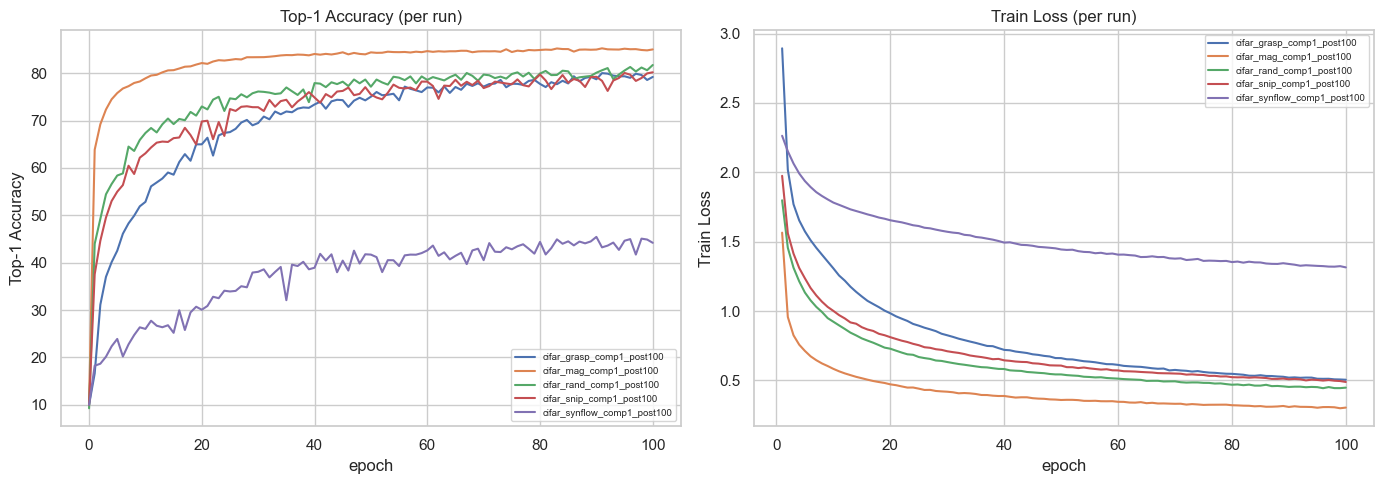

In [ ]:
# Section 8: Plot top-1 accuracy and train loss for all runs in Results/data/singleshot/
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd

runs_dir = Path('Results/data/singleshot')
runs = sorted([p for p in runs_dir.iterdir() if p.is_dir()])

plt.figure(figsize=(14,5))
ax1 = plt.subplot(1,2,1)
for r in runs:
    post = r / 'post-train.pkl'
    pre = r / 'pre-train.pkl'
    label = r.name
    try:
        if post.exists():
            df = pd.read_pickle(post)
        elif pre.exists():
            df = pd.read_pickle(pre)
        else:
            continue
        ax1.plot(df['top1_accuracy'].reset_index(drop=True), label=label)
    except Exception as e:
        print(f'Warning: could not load {r}: {e}')

ax1.set_title('Top-1 Accuracy (per run)')
ax1.set_xlabel('epoch')
ax1.set_ylabel('Top-1 Accuracy')
ax1.legend(fontsize='xx-small', loc='best')

ax2 = plt.subplot(1,2,2)
for r in runs:
    post = r / 'post-train.pkl'
    pre = r / 'pre-train.pkl'
    label = r.name
    try:
        if post.exists():
            df = pd.read_pickle(post)
        elif pre.exists():
            df = pd.read_pickle(pre)
        else:
            continue
        ax2.plot(df['train_loss'].reset_index(drop=True), label=label)
    except Exception as e:
        print(f'Warning: could not load {r}: {e}')

ax2.set_title('Train Loss (per run)')
ax2.set_xlabel('epoch')
ax2.set_ylabel('Train Loss')
ax2.legend(fontsize='xx-small', loc='best')

plt.tight_layout()

# Summary table of final values
summary = []
for r in runs:
    post = r / 'post-train.pkl'
    pre = r / 'pre-train.pkl'
    try:
        if post.exists():
            df = pd.read_pickle(post)
        elif pre.exists():
            df = pd.read_pickle(pre)
        else:
            continue
        summary.append({'expid': r.name,
                        'final_top1': float(df['top1_accuracy'].iloc[-1]),
                        'final_train_loss': float(df['train_loss'].iloc[-1]),
                        'n_epochs': len(df)})
    except Exception as e:
        print(f'Warning: could not summarize {r}: {e}')
        
if summary:
    summary_df = pd.DataFrame(summary).sort_values('final_top1', ascending=False)
    display(summary_df)
else:
    print('No run results found to summarize.')